In [51]:
import numpy as np
import matplotlib.pyplot as plt 
import random                          # crear numeros aleatoriamente
import scipy.io as sio
from sklearn.model_selection import train_test_split

In [52]:
"""
Definicion de funcion que permite extraer
los datos de un arhivo con extension .mat
"""

def datos(data):
    # cargar el archivo .mat
    #data = sio.loadmat('Tiosulfatosodio.mat')

    #Extrayendo matriz de caracteristicas 
    Xi = data['x']

    #Extrayendo dato esperado (Clases)
    Yi = data['y']

    #Agregando el bias a las filas de la matriz de caracteristicas (Entradas)
    bias = np.full((Xi.shape[0], 1), 1)
    Xi = np.hstack((bias, Xi))

    #numero de datos
    num_datos = Xi.shape[0]

    #numero de caracteristicas
    caract = Xi.shape[1]                  # Se resta el bias 

    #Datos de entrenamiento y prueba: entrenamiento 90% , prueba 10%
    X_ent, X_pru, Y_ent, Y_pru = train_test_split(Xi, Yi, test_size=0.1)

    #Obteniendo datos de validacion: Validacion 10% y Entrenamiento 80%
    #Se extraen los datos de validación a partir de los de entrenamiento
    X_ent, X_val, Y_ent, Y_val = train_test_split(X_ent, Y_ent, test_size=0.1, random_state=42)

    #Obteniendo datos de entrenamiento y prueba
    D_entre  =  len(X_ent)       # datos de entrenamiento   (verificar la cantidad de dtos para hacer la particion)
    D_prueba =  len(X_pru)       #Datos de validacion 
    D_val    =  len(X_val)
    
    print("Cantidad de datos del dataset: ",num_datos)
    print("Cantidad de datos de entrenamiento:",D_entre)
    print("Cantidad de datos de prueba:",D_prueba)
    print("Cantidad de datos de Validación:", D_val)
    
    #se grafica la distribución de los datos
    plot_datos(Xi,Yi,X_ent,Y_ent,X_pru,Y_pru,X_val,Y_val)
    
    
    return Xi,Yi,X_ent, Y_ent, D_entre,X_pru,Y_pru, D_prueba,X_val, Y_val, D_val 


In [53]:
#funcion que permite graficar los datos
def plot_datos(Xi,Yi,X_ent,Y_ent,X_pru,Y_pru,X_val,Y_val):
    
    # Crear la figura y los subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 14))

    # Graficar la segunda gráfica en el segundo subplot
    axs[0, 0].scatter(Xi[:, 1], Xi[:, 2], c=Yi, cmap=plt.cm.coolwarm)
    axs[0, 0].set_title('Datos Originales', fontsize=18)
    axs[0, 0].set_xlabel('X1', fontsize=14)
    axs[0, 0].set_ylabel('X2', fontsize=14)

    # Graficar la primera gráfica en el primer subplot
    axs[0, 1].scatter(X_ent[:, 1], X_ent[:, 2], c=Y_ent, cmap=plt.cm.coolwarm)
    axs[0, 1].set_title('Datos de Entrenamiento', fontsize=18)
    axs[0, 1].set_xlabel('X1', fontsize=14)
    axs[0, 1].set_ylabel('X2', fontsize=14)

    # Graficar la tercera gráfica en el tercer subplot
    axs[1, 0].scatter(X_pru[:, 1], X_pru[:, 2], c=Y_pru, cmap=plt.cm.coolwarm)
    axs[1, 0].set_title('Datos de Prueba', fontsize=18)
    axs[1, 0].set_xlabel('X1', fontsize=14)
    axs[1, 0].set_ylabel('X2', fontsize=14)

    # Graficar la cuarta gráfica en el cuarto subplot
    axs[1, 1].scatter(X_val[:, 1], X_val[:, 2], c=Y_val, cmap=plt.cm.coolwarm)
    axs[1, 1].set_title('Datos de Validación', fontsize=18)
    axs[1, 1].set_xlabel('X1', fontsize=14)
    axs[1, 1].set_ylabel('X2', fontsize=14)

    # Mostrar la figura
    plt.show()

In [54]:
"""
Definicion de funciones de activación y 
sus respectivas derivadas
"""


def sigmoide(x):
    """
    Función de activación sigmoide
    """
    #return 1 / (1 + np.exp(-x))

    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

def sigmoide_derivative(x):
    """
    Derivada de la función de activación sigmoide
    """
    return sigmoide(x) * (1 - sigmoide(x))

def tanh(x):
    """
    Función de activación tangente hiperbolica
    """
    return np.tanh(x)

def tanh_derivative(x):
    """
    Derivada de la función de activación tangente hiperbolica
    """
    return (1-np.tanh(x)**2)



In [55]:
"""
Definicion de funciones para el calculo del error de prueba y entrenamiento
"""

def Error_calculation(X,Y,weights,hidden_layers):
    e = 0
    layer_outputs = [X]
    for i in range(hidden_layers+1):
        layer_input = layer_outputs[-1] @ weights[i]
        layer_output = tanh(layer_input)
        layer_outputs.append(layer_output)
        
    y_pred = np.where(layer_outputs[-1] >= 0.5, 1, -1)
    
    for j in range(Y.shape[0]):
            if not (Y[j] == y_pred[j]):
                e = e+1
                
    return e

In [56]:
"""
Definicion de funcion red neuronal multicapa
con capas ocultas y cantidad de redes neuronales variables

"""

def perceptron_multicapa(X_ent, Y_ent, X_pru, Y_pru,X_val,Y_val, hidden_layers, hidden_units, lr, epochs):
    """
    X_ent: matriz de características (muestra x características)
    Y_ent: vector de etiquetas (muestra x 1)
    hidden_layers: número de capas ocultas
    hidden_units: número de unidades en cada capa oculta (lista de longitud hidden_layers)
    lr: tasa de aprendizaje
    epochs: número de iteraciones sobre el conjunto de entrenamiento
    """
    Error_ent = []
    Error_pru = []
    Error_val = []
    
    # Inicialización aleatoria de los pesos
    input_units = X_ent.shape[1]
    output_units = 1
    layers_units = [input_units] + hidden_units + [output_units]
    weights = [np.random.rand(layers_units[i], layers_units[i+1]) for i in range(hidden_layers+1)]

    # Bucle de entrenamiento
    for epoch in range(epochs):
        e = 0
        ep = 0
        # Propagación hacia adelante
        layer_outputs = [X_ent]
        for i in range(hidden_layers+1):
            layer_input = layer_outputs[-1] @ weights[i]
            layer_output = tanh(layer_input)
            layer_outputs.append(layer_output)

        # Cálculo del error y la derivada de la función de activación en la capa de salida
        error = Y_ent - layer_outputs[-1]
        delta = error * tanh_derivative(layer_outputs[-1])

        # Propagación hacia atrás
        for i in range(hidden_layers-1, -1, -1):
            delta = delta @ weights[i+1].T * tanh_derivative(layer_outputs[i+1])
            weights[i] += layer_outputs[i].T @ delta * lr

        # Cálculo del error de entrenamiento
        eent = Error_calculation(X_ent,Y_ent,weights,hidden_layers)
        error_ent = eent*100.0/Y_ent.shape[0]
        Error_ent.append(error_ent)
        
        
         # Cálculo del error de Prueba
        epru = Error_calculation(X_pru,Y_pru,weights,hidden_layers)
        error_pru = epru*100/Y_pru.shape[0]
        Error_pru.append(error_pru)
            
            
         # Cálculo del error de validacion
        evald  = Error_calculation(X_val,Y_val,weights,hidden_layers)
        error_val = evald*100/Y_val.shape[0]
        Error_val.append(error_val)
       
    

    return Error_ent,Error_pru, Error_val



# Dataset 1
## Archivo Tiosulfatosodio.mat que consta de un proceso quimico en dónde se busca identificar dos clases: 1(normal) y -1(fallo)

Cantidad de datos del dataset:  400
Cantidad de datos de entrenamiento: 324
Cantidad de datos de prueba: 40
Cantidad de datos de Validación: 36


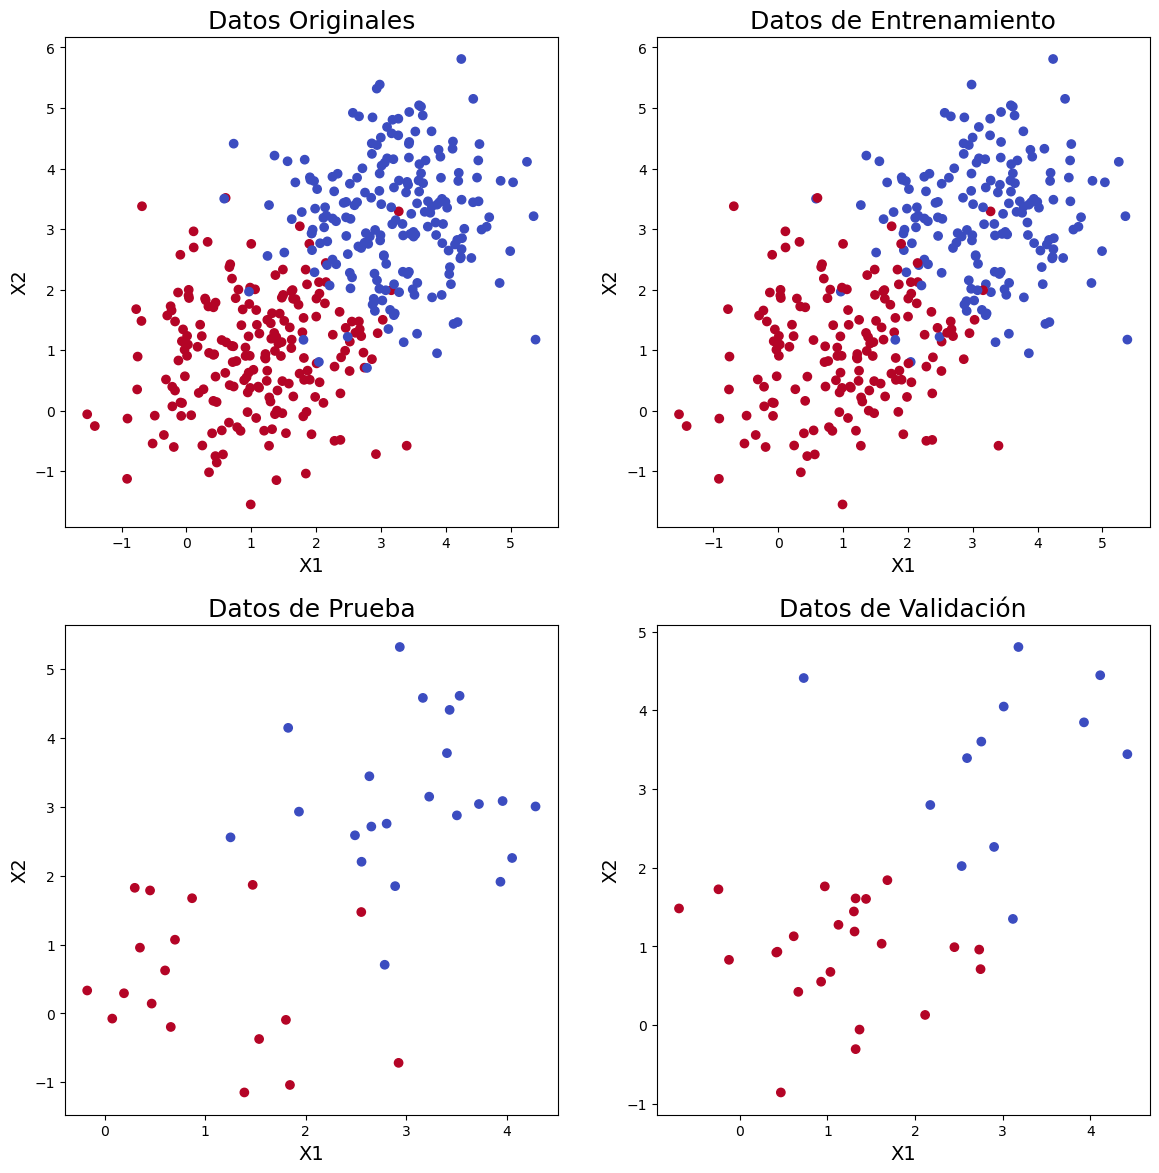

In [57]:
data = sio.loadmat('Tiosulfatosodio.mat') # cargar el archivo .mat
Xi,Yi,X_ent, Y_ent, D_entre,X_pru,Y_pru, D_prueba,X_val, Y_val, D_val = datos(data)


In [58]:
######  Parametros para la red neuronal   #########

hidden_layers = 3        #Capas ocultas que definimos 
hidden_units = [4,3,2]   #Cantidad de red neuronal por cada capa oculta 

u = 0.0009              #Tasa aprendizaje
iteraciones = 6000

error_ent,error_pru,error_val = perceptron_multicapa(X_ent, Y_ent,X_pru,Y_pru,X_val,Y_val, hidden_layers, hidden_units, u, iteraciones)

            
print(f"Error entrenamiento:  {round(error_ent[-1],2)}%" )
print(f"Error de prueba: {round(error_pru[-1],2)}%")
print(f"Error de Validacion : {round(error_val[-1],2)}%")


Error entrenamiento:  6.17%
Error de prueba: 7.5%
Error de Validacion : 0.0%


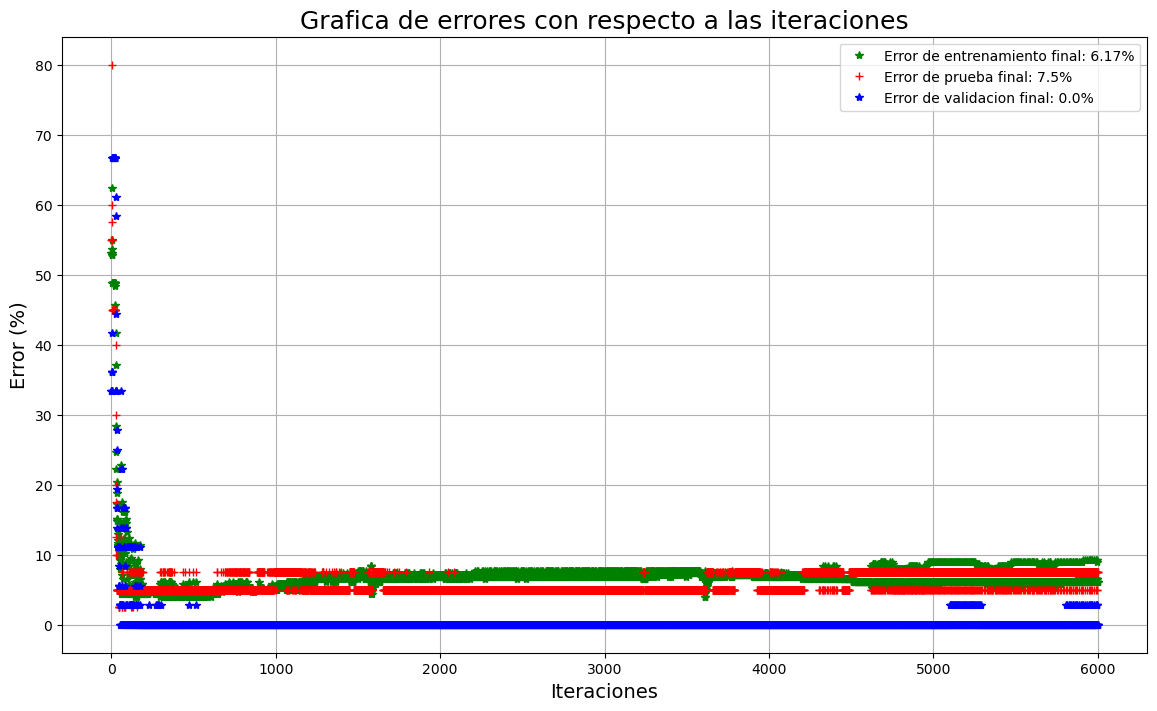

In [59]:
############# Grafica para los tres errores de interes  ###################
#Error de entrenamiento, prueba y validacion 

plt.figure(figsize=(14,8))
plt.title(label="Grafica de errores con respecto a las iteraciones",fontsize=18)
plt.plot(error_ent , 'g*' ,label= f"Error de entrenamiento final: {round(error_ent[-1],2)}%")
plt.plot(error_pru , 'r+' ,label = f"Error de prueba final: {round(error_pru[-1],2)}%")
plt.plot(error_val , 'b*' ,label = f"Error de validacion final: {round(error_val[-1],2)}%")

plt.legend()
plt.xlabel('Iteraciones',fontsize=14)
plt.ylabel('Error (%)',fontsize=14)
plt.grid()

# Dataset 2
## Archivo de Esterificacion.mat que consta de un procesos quimica, donde se busca identificar dos clases, 1 o -1.

Cantidad de datos del dataset:  600
Cantidad de datos de entrenamiento: 486
Cantidad de datos de prueba: 60
Cantidad de datos de Validación: 54


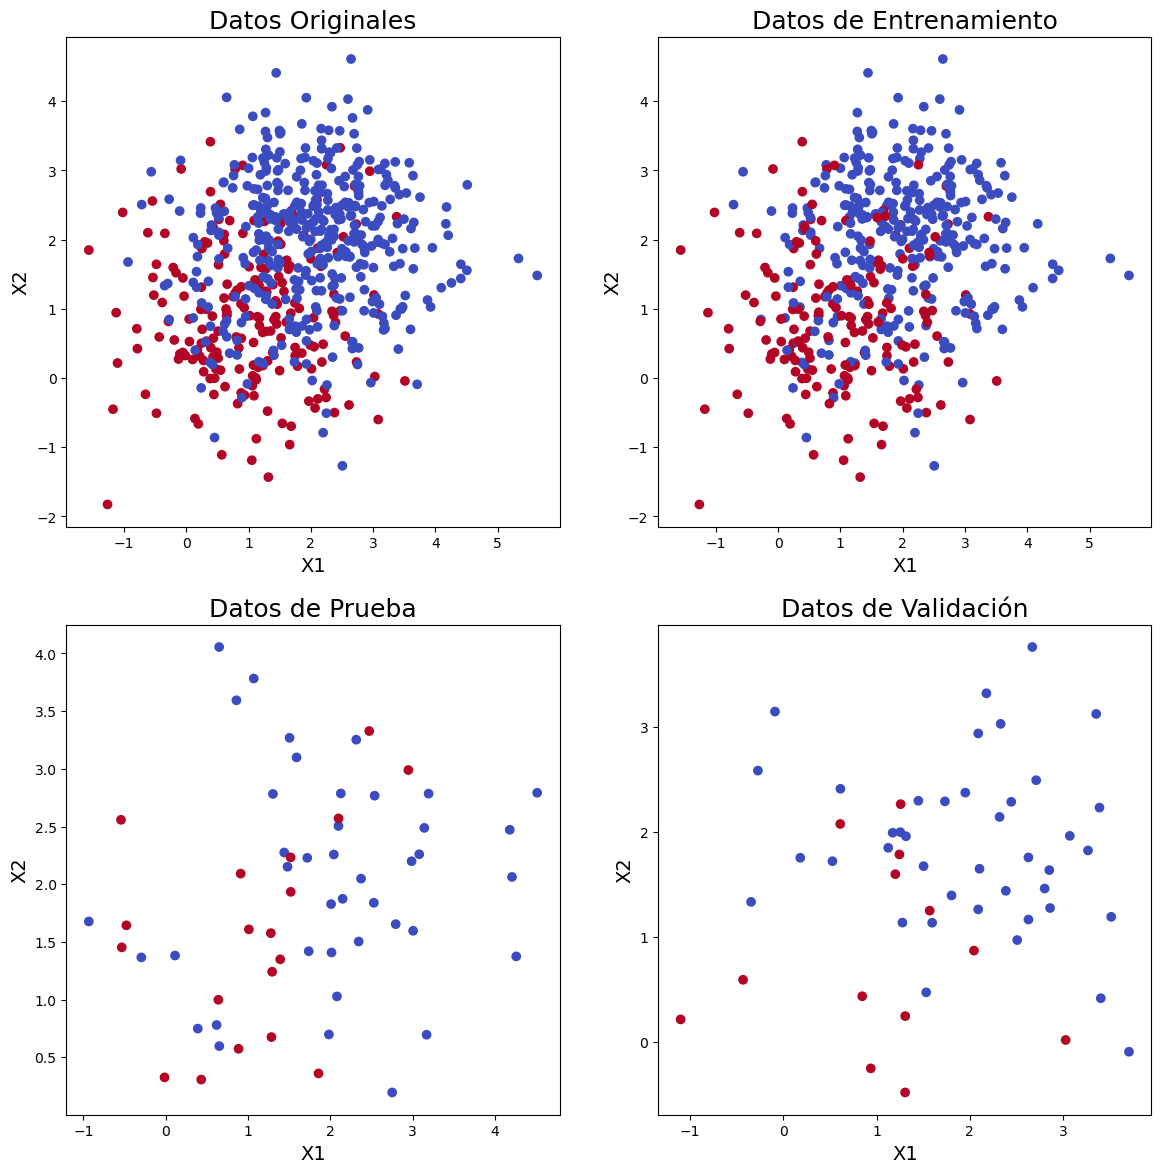

In [67]:
data = sio.loadmat('esterificacion.mat') # cargar el archivo .mat
Xi,Yi,X_ent, Y_ent, D_entre,X_pru,Y_pru, D_prueba,X_val, Y_val, D_val = datos(data)


In [72]:
######  Parametros para la red neuronal   #########

hidden_layers = 3        #Capas ocultas que definimos 
hidden_units = [8,4,2]   #Cantidad de red neuronal por cada capa oculta 

u = 0.0001              #Tasa aprendizaje
iteraciones = 12000

error_ent,error_pru,error_val = perceptron_multicapa(X_ent, Y_ent,X_pru,Y_pru,X_val,Y_val, hidden_layers, hidden_units, u, iteraciones)

            
print(f"Error entrenamiento:  {round(error_ent[-1],2)}%" )
print(f"Error de prueba: {round(error_pru[-1],2)}%")
print(f"Error de Validacion : {round(error_val[-1],2)}%")

Error entrenamiento:  30.25%
Error de prueba: 30.0%
Error de Validacion : 20.37%


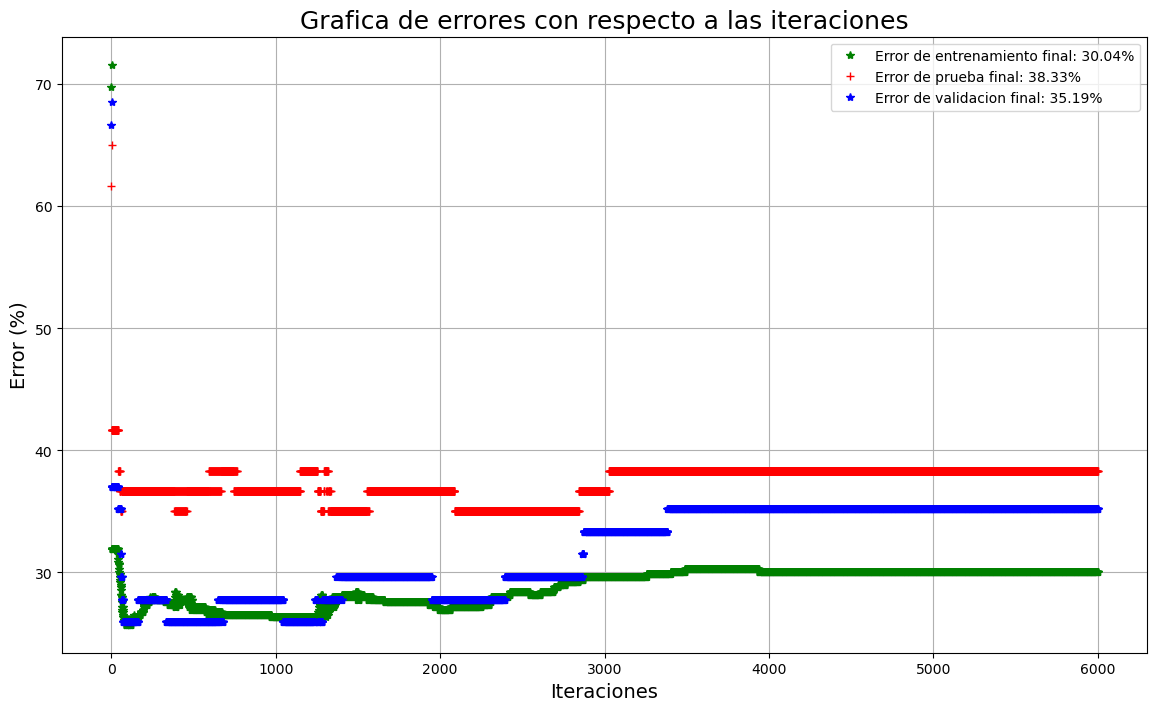

In [64]:
############# Grafica para los tres errores de interes  ###################
#Error de entrenamiento, prueba y validacion 

plt.figure(figsize=(14,8))
plt.title(label="Grafica de errores con respecto a las iteraciones",fontsize=18)
plt.plot(error_ent , 'g*' ,label= f"Error de entrenamiento final: {round(error_ent[-1],2)}%")
plt.plot(error_pru , 'r+' ,label = f"Error de prueba final: {round(error_pru[-1],2)}%")
plt.plot(error_val , 'b*' ,label = f"Error de validacion final: {round(error_val[-1],2)}%")

plt.legend()
plt.xlabel('Iteraciones',fontsize=14)
plt.ylabel('Error (%)',fontsize=14)
plt.grid()